In [40]:
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [7]:
import pandas as pd

In [53]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('nkjp-forms-all-100-cbow-hs.txt', binary=False)


In [63]:
df = pd.read_excel('cyberbullying_train_words_noun.xlsx')
df

,nouns,label1,label2,label3,SUPERanotator,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,LUDZIE,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RESTAURACJA,1.0,1.0,1.0,1.0,NaN,NaN,do 200 wszystkie,NaN,NaN,2. Anotacja według semantyki (znaczenia)\nOsob...,NaN
2,pomoc,2.0,2.0,2.0,2.0,NaN,NaN,od 201 do 300 Iza,NaN,NaN,NaN,NaN
3,świat,3.0,3.0,3.0,3.0,NaN,NaN,później jakoś tam,NaN,NaN,NaN,NaN
4,kurtkę,1.0,1.0,1.0,1.0,NaN,NaN,od 301 do 400 Julita,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
628,inwestor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629,wycofał,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
630,slabo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
631,dzieci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df_for_analysis = df[['nouns', 'SUPERanotator']][:601]
df_for_analysis.columns = ['nouns', 'labels']

In [65]:
df_for_analysis['labels'].unique()

array([ 0.,  1.,  2.,  3., nan])

In [66]:
def clean_text(text):
    text = re.sub(r'@anonymized_account', '', text)
    text = re.sub(r'RT', '', text)
    # text = re.sub(r'[^\x00-\x7F]+', '', text)
    # text = re.sub(r'\s+', ' ', text).strip()
    return text

In [67]:
import re
df_for_analysis['nouns'] = df_for_analysis['nouns'].apply(clean_text)
df_for_analysis

,nouns,labels
0,LUDZIE,0.0
1,RESTAURACJA,1.0
2,pomoc,2.0
3,świat,3.0
4,kurtkę,1.0
...,...,...
596,Mistrzowie,0.0
597,branża,2.0
598,mirda,2.0
599,kubeł,1.0


In [68]:
import numpy as np

def get_sentence_vector(sentence):
    # Tokenize the sentence into words
    words = sentence.split()
    # Get the word vectors for each word in the sentence
    word_vectors = [model[word] for word in words if word in model]
    # Return the mean of the word vectors or a zero vector if no words are found
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)


In [69]:
df_for_analysis['embedding'] = df_for_analysis['nouns'].apply(get_sentence_vector)

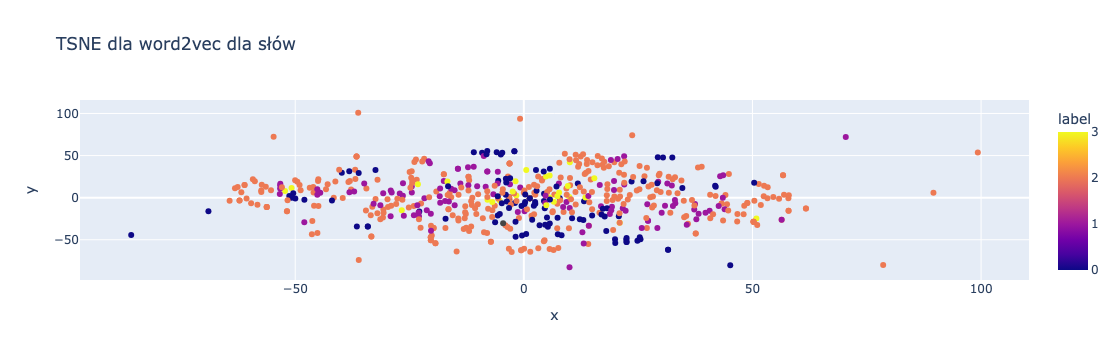

In [70]:
X = np.array(list(df_for_analysis['embedding']))

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)


X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_standardized)

df_tsne = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_tsne['label'] = df_for_analysis['labels']
df_tsne['text'] = df_for_analysis['nouns']

fig = px.scatter(df_tsne, x='x', y='y', color='label', hover_data=['text'], title='TSNE dla word2vec dla słów')
fig.show()

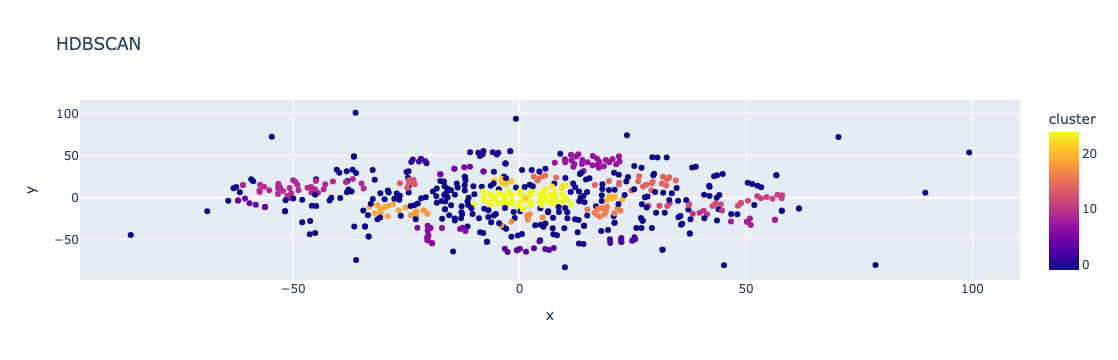

In [71]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
df_tsne['cluster'] = clusterer.fit_predict(X_embedded)

fig = px.scatter(df_tsne, x='x', y='y', color='cluster', hover_data=['text'], title='HDBSCAN')
fig.show()